In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras.layers import Convolution2D,Dense,MaxPool2D,Activation,Dropout,Flatten
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D

In [ ]:
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count
train_dir ="/content/drive/MyDrive/small_dataset/Train"
test_dir="/content/drive/MyDrive/small_dataset/Test"

In [ ]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir)
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

2 Classes
6 Train images
4 Test images


In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
    )
test_datagen=ImageDataGenerator(rescale=1./255)

In [ ]:
input_shape=(224,224,3)
train_generator =train_datagen.flow_from_directory(train_dir,target_size=(224,224),batch_size=32)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,target_size=(224,224),batch_size=32)

Found 6 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [ ]:
def create_Base_model_from_VGG16():
    model = VGG16(
        weights = "imagenet",
        include_top=False,
        input_shape = (224,224, 3)
        )
    for layer in model.layers:
      layer.trainable = False
    return model
create_Base_model_from_VGG16().summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def add_custom_layers():
    model = create_Base_model_from_VGG16()
    x = model.output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    predictions = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    final_model = tf.keras.models.Model(
        inputs = model.input,
        outputs = predictions)

    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return final_model
add_custom_layers().summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
validation_generator = train_datagen.flow_from_directory(
                       test_dir,
                       target_size=(224, 224),
                       batch_size=32)

Found 4 images belonging to 2 classes.


In [ ]:
model_from_vgg16 = add_custom_layers()
history2 = model_from_vgg16.fit(
    train_generator,
    steps_per_epoch=None,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=None,
    verbose=1,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)],
    use_multiprocessing=False,
    shuffle=True
    )

Epoch 1/5
1/1 [==============================] - 8s 8s/step - loss: 0.8278 - accuracy: 0.5000 - val_loss: 4.0571 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/5
1/1 [==============================] - 7s 7s/step - loss: 1.8256 - accuracy: 0.6667 - val_loss: 6.6434 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/5
1/1 [==============================] - 9s 9s/step - loss: 3.1805 - accuracy: 0.5000 - val_loss: 5.9347 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/5
1/1 [==============================] - 6s 6s/step - loss: 1.6800 - accuracy: 0.8333 - val_loss: 3.4801 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/5
1/1 [==============================] - 7s 7s/step - loss: 8.3446e-07 - accuracy: 1.0000 - val_loss: 2.4691 - val_accuracy: 0.7500 - lr: 0.0010


In [ ]:
model_from_vgg16.save('/content/drive/MyDrive/Colab Notebooks/Model/model_VGG16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
model_vgg16=load_model('/content/drive/MyDrive/Colab Notebooks/Model/model_VGG16.h5')

1/1 [==============================] - 1s 551ms/step
Disease


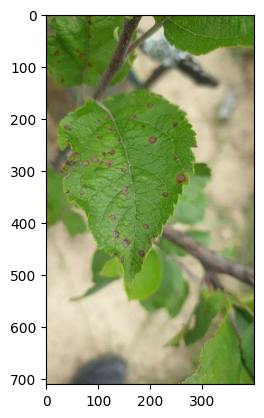

In [ ]:
classes=list(train_generator.class_indices.keys())
def prepare(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)
img_url='/content/apple5.png'
result_vgg16 = model_vgg16.predict([prepare(img_url)])
disease=image.load_img(img_url)
plt.imshow(disease)
classresult=np.argmax(result_vgg16,axis=1)
print(classes[classresult[0]])